In [60]:
import os
import torch

import torch.nn as nn
import torchvision as tv
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

from torchsummary import summary
import matplotlib.pyplot as plt
import random

from torchmetrics.classification import MulticlassROC
from torchmetrics.classification import MulticlassConfusionMatrix
from torcheval.metrics.functional import multiclass_f1_score

#torch.cuda.is_available()

In [61]:
class DatasetLoader(Dataset):
    def __init__(self, metadata, img_dir, transform=None):
        """
        Args:
            metadata (DataFrame): DataFrame containing image file names and labels.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.metadata = metadata
        self.img_dir = img_dir
        self.transform = transform
        # Create a mapping for class names to indices
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(metadata['dx'].unique())}

    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        #lesion_id, image_id, dx, dx_type, age, sex, localization
        img_name = os.path.join(self.img_dir, self.metadata.iloc[idx, 1] + '.jpg')
        image = Image.open(img_name)
        label_name = self.metadata.iloc[idx,2]
        label = self.class_to_idx[label_name]
        filename = self.metadata.iloc[idx, 1]
    
        if self.transform:
            image = self.transform(image)

        return image, label, filename

def get_metadata(metadata_path,label_list):

    project_df = pd.read_csv(metadata_path)

    #print(project_df.columns)
    #print(project_df.head(n=5))
    #print(project_df.info())

    row_indices = []

    for label_i in label_list:
        # Find all the rows of the dataframe corresponding to label i
        #print(label_i)
        rows_of_i = project_df.loc[project_df['dx'] == label_i]
        indices_of_i = list(rows_of_i.index)
        indices_of_i_random = random.sample(indices_of_i,min(150,len(rows_of_i)))
    
        row_indices.extend(indices_of_i_random)


    row_indices.sort()

    #print("==========================")
    #print(len(row_indices)) #Should print 1007
    
    working_df = project_df.iloc[row_indices]
    #print(working_df.info())
    #print(working_df.head(n=5))

    return working_df

img_path = './data/images/'
metadata_path = './data/HAM10000_metadata.csv'

label_list = ['akiec','bcc','bkl','df','mel','nv','vasc']
#'akiec' #327 images
#'bcc' #514 images
#'bkl' #1099 images
#'df' #115 images
#'mel' #1113 images
#'nv' #6705 images
#'vasc' #142 images

#metadata = get_metadata(metadata_path,label_list)

#dataset = DatasetLoader(metadata=metadata, img_dir=img_path, transform=transform)
#print(len(dataset))



In [62]:
transform = tv.transforms.Compose([
    tv.transforms.Resize((64,64)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_path = './data/images/'
metadata_path = './data/HAM10000_metadata.csv'
metadata = get_metadata(metadata_path,label_list)
dataset = DatasetLoader(metadata=metadata, img_dir=img_path, transform=transform)

In [63]:
# Split the dataset 60-20-20
train_size = int(0.6 * len(dataset))
validation_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - validation_size
print("Training Set Size: ",train_size)
print("Validation Set Size: ",validation_size)
print("Test Set Size: ",test_size)
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

batch_size = 32 #Try SGD with minibatch size of 1.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training Set Size:  604
Validation Set Size:  201
Test Set Size:  202


Trying visualization


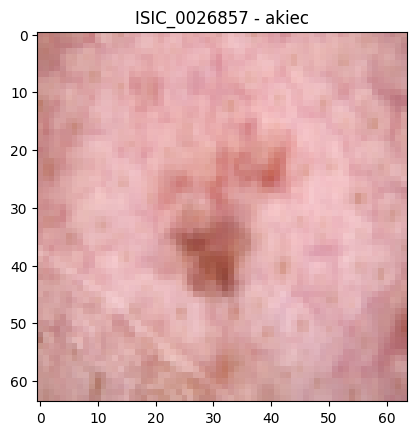

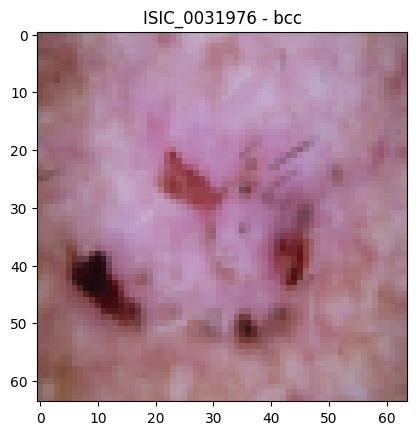

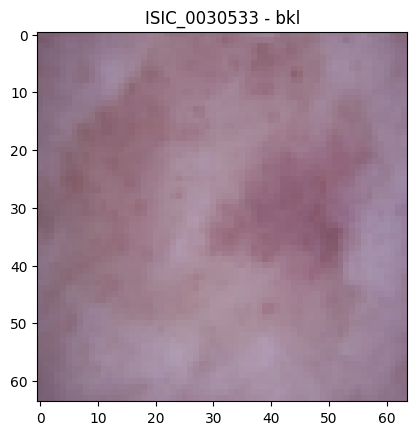

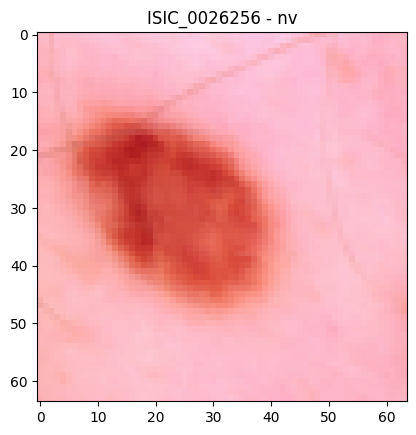

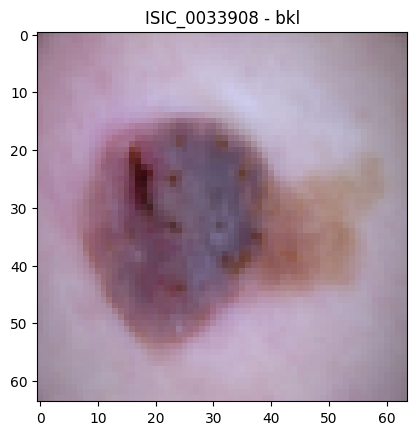

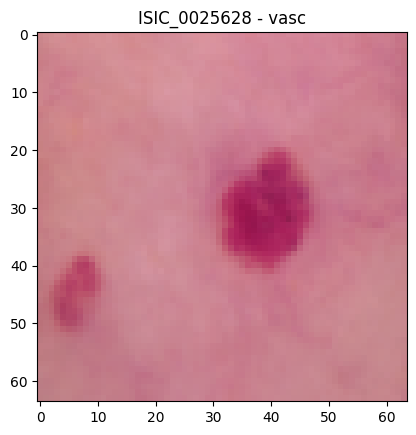

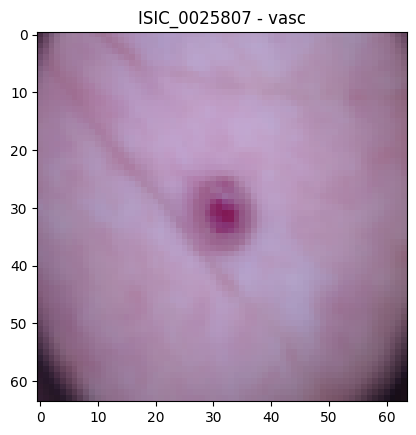

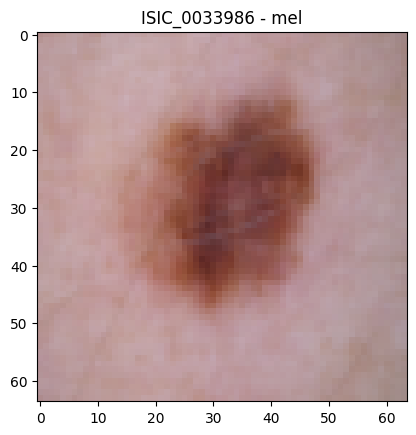

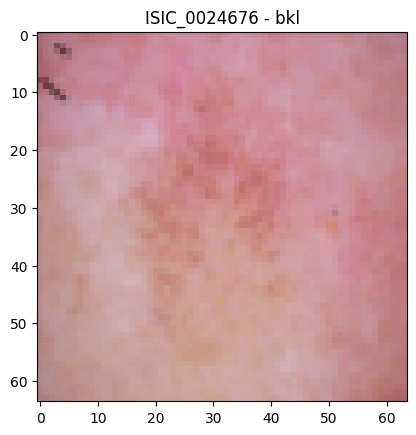

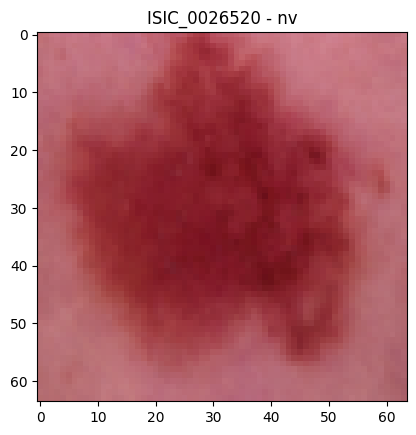

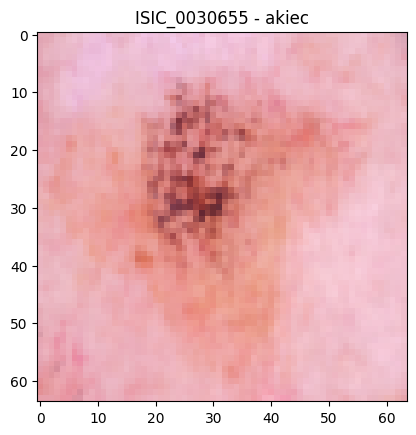

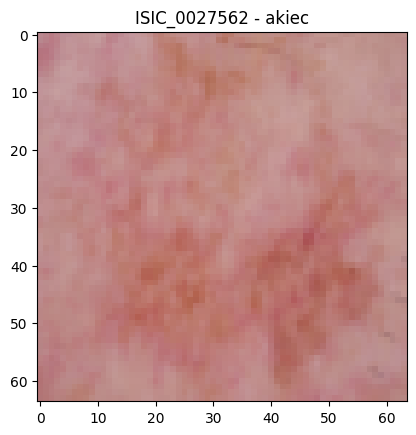

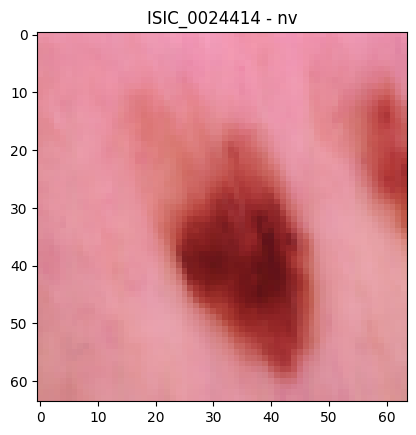

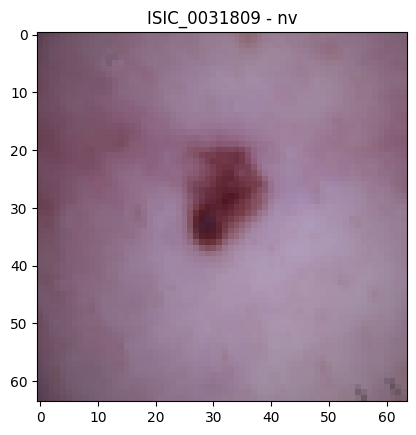

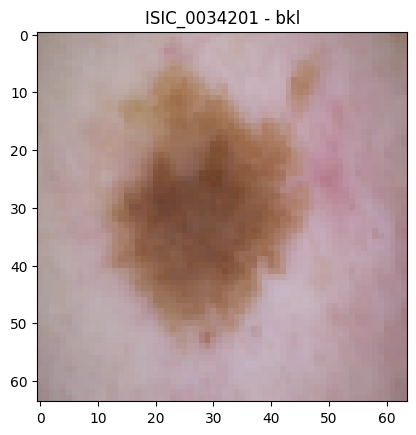

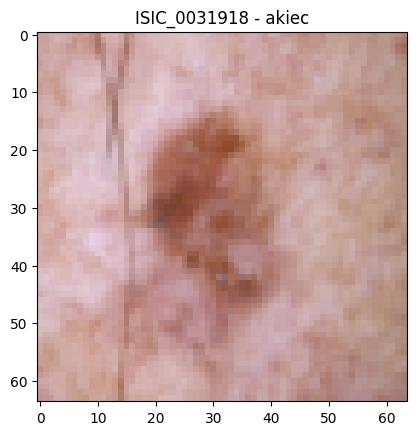

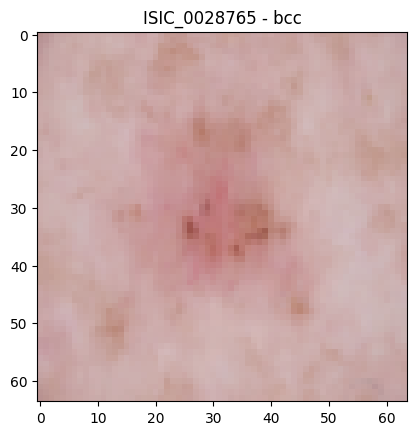

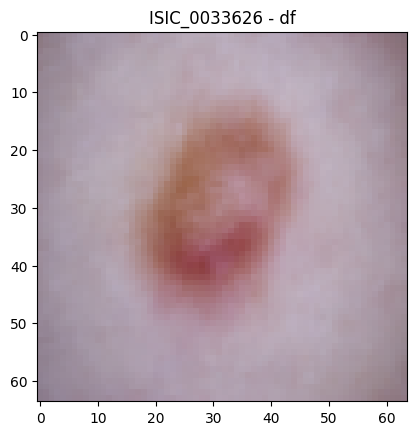

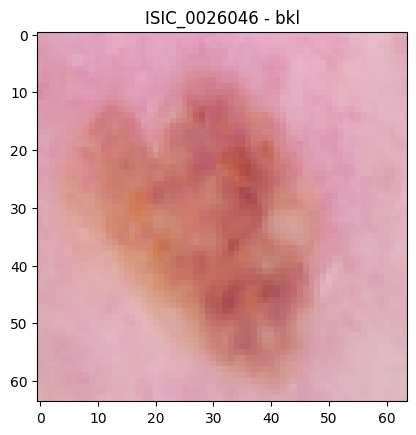

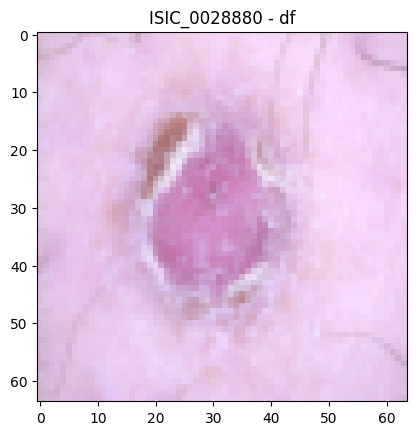

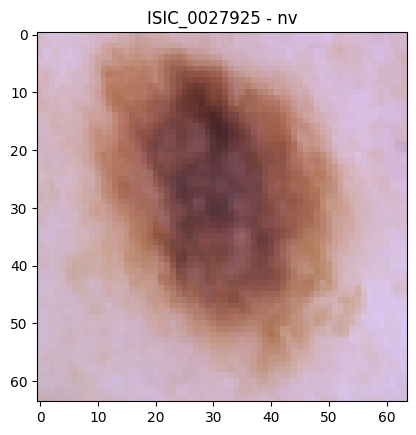

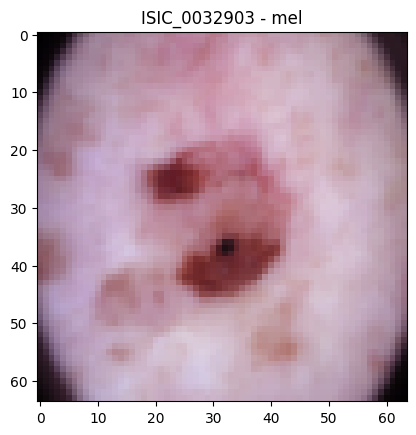

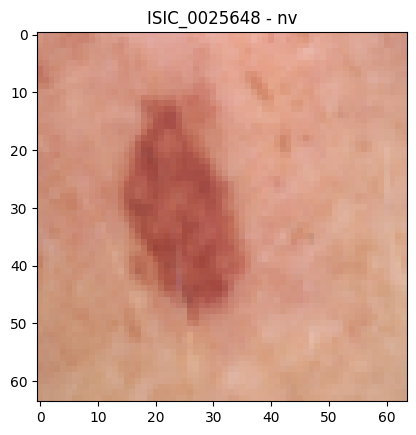

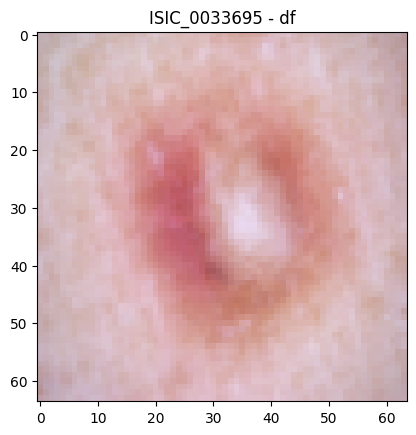

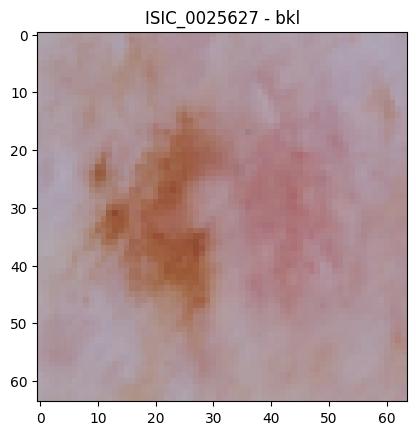

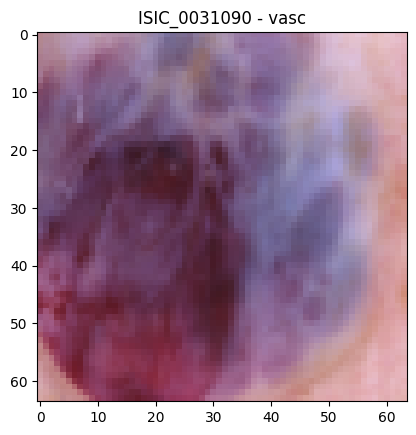

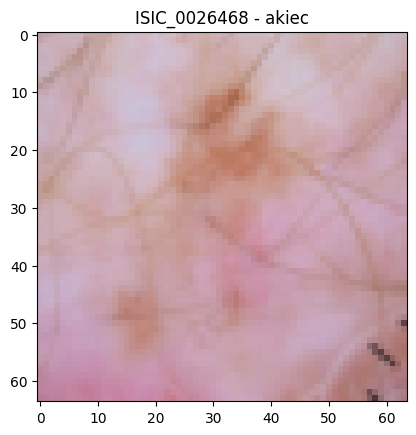

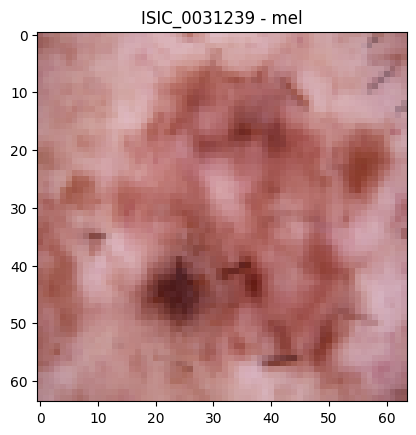

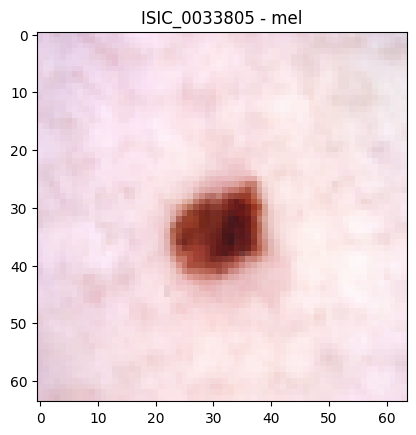

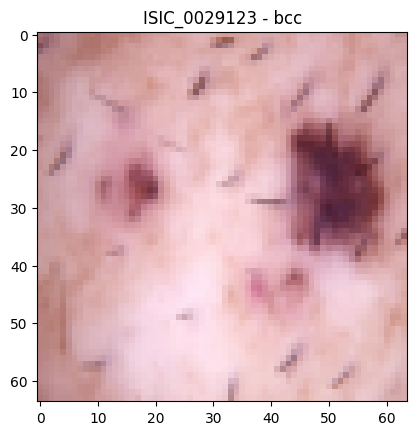

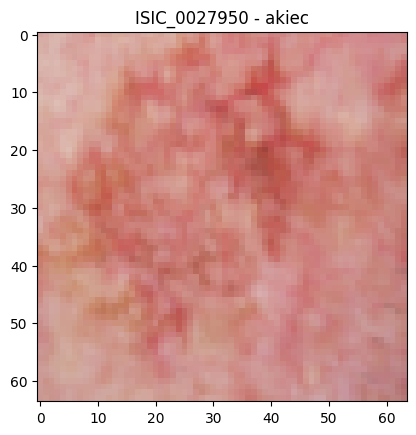

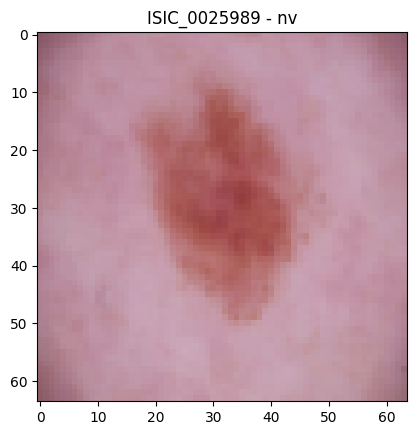

32


In [64]:
#Used ChatGPT to generate this code to make sure that the images are properly extracted

print("Trying visualization")

class_names = metadata['dx'].unique().tolist()

def imshow(inp, label, filename, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip to the valid range [0,1]
    plt.imshow(inp)
    
    plt.title(f"{filename} - {class_names[label]}")
    plt.show()

# Get a batch of training data
inputs, classes, filenames = next(iter(train_loader))

# Visualize each image with its filename and label
for i in range(len(inputs)):
    imshow(inputs[i], classes[i], filenames[i])

print(len(inputs))

In [65]:
class DCNN(nn.Module):

    def __init__(self):
        super(DCNN,self).__init__()

        #3 Pairs of convolution and max pool layers
        #Some reference tutorials: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
        # as well as from the Pytorch documentation of each layer

        ##Assume input image of size 64x64
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1)
        self.maxpool2d_1 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)
        self.maxpool2d_2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1)
        self.maxpool2d_3 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(4608,512)
        self.fc2 = nn.Linear(512,7)

        #self.flatten = nn.Flatten()
        #self.fc1 = nn.Linear(12544,512)
        #self.fc2 = nn.Linear(512,7)

    # x represents our data
    def forward(self, x):
      
        x = self.conv1(x) #Input data first passed through conv1
        x = F.relu(x) #Then we pass it through RELU (introduce nonlinearity)
        x = self.maxpool2d_1(x) #Pass through maxpool 2D layer
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2d_2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool2d_3(x)
        
        #x = torch.flatten(x,1)
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        #x = F.relu(x)

        #print("x before log_softmax:", x)
        
        x = F.log_softmax(x, dim=1)

        #print("x after log_softmax:", x)


        return x

In [66]:
# Step 1: Instantiate the model
model = DCNN()

summary(model,(3,64,64))
#summary(model,(3,64,64))
#assert False

#device = torch.device("cpu") #not "cuda"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move your model to GPU if cuda is available

# Step 2: Define a loss function
criterion = nn.CrossEntropyLoss()

# Step 3: Choose an optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)  # You can also try different learning rates

# Step 4: Training loop
num_epochs = 5 # Set the number of epochs
epoch_list = [i+1 for i in range(num_epochs)]
max_iter = num_epochs-1
#num_epochs = 20  # Set the number of epochs

# print("Model Parameters: ", print(model))
# k = 0
# for param in model.parameters():
#     print(k)
#     k+=1
#     print(type(param))
#     #print(param)
# print(model.layers[0].weight)

# j = 0
# for param in model.parameters():
#     print("Layer ", j+1, " Parameters: ")
#     if j == 1:
#         print(param)
#     print(type(param), param.size())
#     j+=1

#assert False

val_loss_vec = []
val_acc_vec = []
test_loss_vec = []
test_acc_vec = []

final_predictions = []
final_actuals = []
final_outputs = []

for epoch in range(num_epochs):
    print("Epoch: ",epoch)
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels, _ in train_loader:

        #print("New Minibatch")
        # j = 0
        # for param in model.parameters():
        #     if j == 1:
        #         print("Layer ", j+1, " Parameters: ")
        #         print(param)
            #print(type(param), param.size())
            #j+=1
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        #print("Outputs: ",outputs)
        #print("Labels: ",labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}')

    # Validation loop (optional, but recommended)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        j=0
        for images, labels, _ in validation_loader:
            j+=1
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            temp_loss = criterion(outputs, labels)
            val_loss = temp_loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(validation_loader.dataset)
    val_accuracy = val_correct / val_total
    print(f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    # Test loop (optional, but recommended)
    model.eval()  # Set the model to evaluation mode (even for Testing)
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        j=0
        for images, labels, _ in test_loader:
            j+=1
            #print("Validation Iteration: ",j)
            #print("Count of images: ", len(images))
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
                
            #print("Outputs[0]: ",outputs[0])
            temp_loss = criterion(outputs, labels)
            test_loss = temp_loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            if epoch == max_iter:
                final_predictions.append(predicted)
                final_actuals.append(labels)
                final_outputs.append(outputs)
            #print("Predicted: ",predicted)
            #print("Labels: ",labels)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            #print("Correct: ",correct)

            #assert False

    epoch_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = test_correct / test_total
    print(f'Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    val_loss_vec.append(epoch_val_loss)
    val_acc_vec.append(val_accuracy)
    test_loss_vec.append(epoch_test_loss)
    test_acc_vec.append(test_accuracy)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]             896
         MaxPool2d-2           [-1, 32, 31, 31]               0
            Conv2d-3           [-1, 64, 29, 29]          18,496
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5          [-1, 128, 12, 12]          73,856
         MaxPool2d-6            [-1, 128, 6, 6]               0
           Flatten-7                 [-1, 4608]               0
            Linear-8                  [-1, 512]       2,359,808
            Linear-9                    [-1, 7]           3,591
Total params: 2,456,647
Trainable params: 2,456,647
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.89
Params size (MB): 9.37
Estimated Total Size (MB): 11.31
--------------------------------------

<class 'list'>
<class 'list'>
<class 'list'>
torch.Size([202, 7])
torch.Size([202])
torch.Size([202])


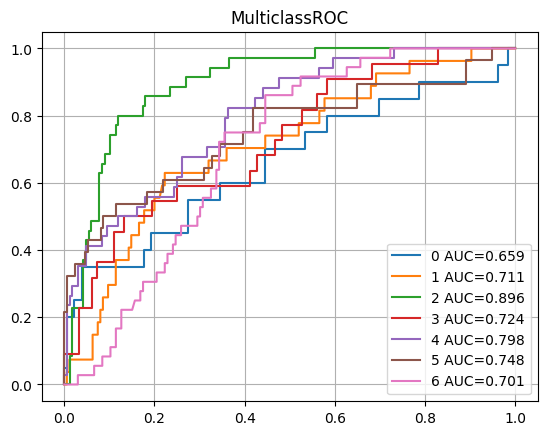

In [67]:
print(type(final_outputs))
print(type(final_actuals))
print(type(final_predictions))
final_outputs = torch.cat(final_outputs)
final_actuals = torch.cat(final_actuals)
final_predictions = torch.cat(final_predictions)
print(final_outputs.shape)
print(final_actuals.shape)
print(final_predictions.shape)

metric = MulticlassROC(num_classes=7)
metric.update(final_outputs, final_actuals)
fig_, ax_ = metric.plot(score=True)

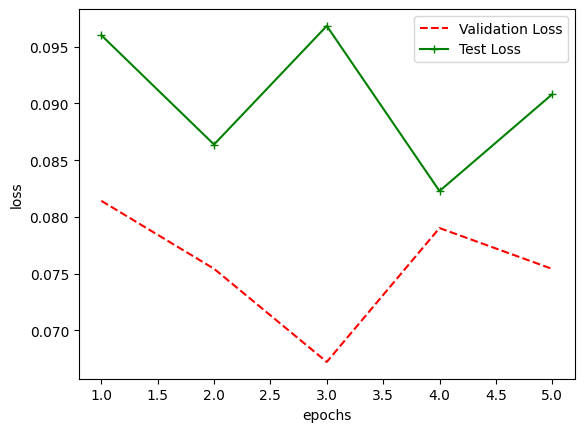

In [68]:
plt.plot(epoch_list,val_loss_vec,'r--',epoch_list,test_loss_vec,'g-+')
plt.legend(['Validation Loss','Test Loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

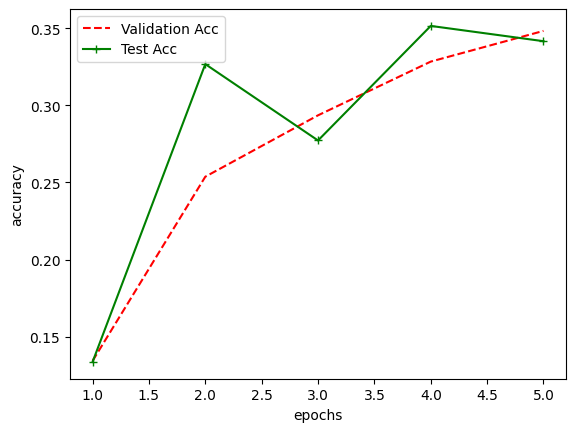

In [69]:
plt.plot(epoch_list,val_acc_vec,'r--',epoch_list,test_acc_vec,'g-+')
plt.legend(['Validation Acc','Test Acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

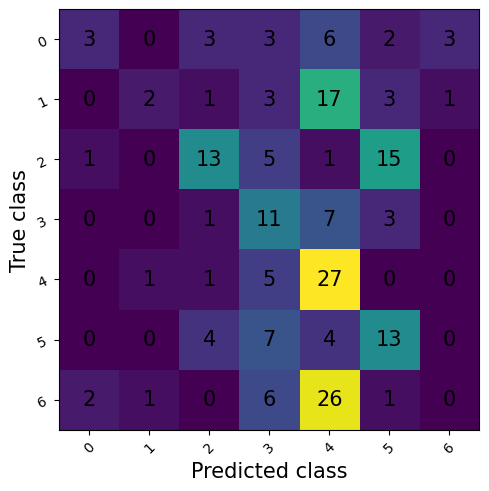

In [70]:
metric = MulticlassConfusionMatrix(num_classes=7)
metric.update(final_predictions, final_actuals)
fig_, ax_ = metric.plot()

In [71]:
multiclass_f1_score(final_predictions, final_actuals, num_classes=7)

tensor(0.3416)